# Lipschitz constant of a convolutional layer in neural network

It was observed, that small perturbation in Neural Network input could lead to significant errors, i.e. misclassifications. Picture below from the [article](https://escholarship.org/content/qt3k2780bg/qt3k2780bg_noSplash_e0803cb722032c480ec3468d84e60e2a.pdf?t=qqf3iz).

![https://fmin.xyz/docs/applications/adv_attack.png](https://fmin.xyz/docs/applications/adv_attack.png)

Lipschitz constant bounds the magnitude of the output of a function, so it cannot change drastically with a slight change in the input

$$
\|NN(image) - NN(image+\varepsilon)\| \leq L\|\varepsilon\|
$$

In this notebook we will try to estimate Lipschitz constant of some convolutional layer of a Neural Network.

## Power method for the singular value estimation

### Download pretrained model
We will use resnet18 model, which was already pretrained on the ImageNet dataset. Feel free to use another model or layer.

In [1]:
import torch
import random
import copy
import numpy as np
from matplotlib import pyplot as plt
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/bratishka/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/bratishka/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:08<00:00, 5.45MB/s]


## Download nice picture of dog to put in the network

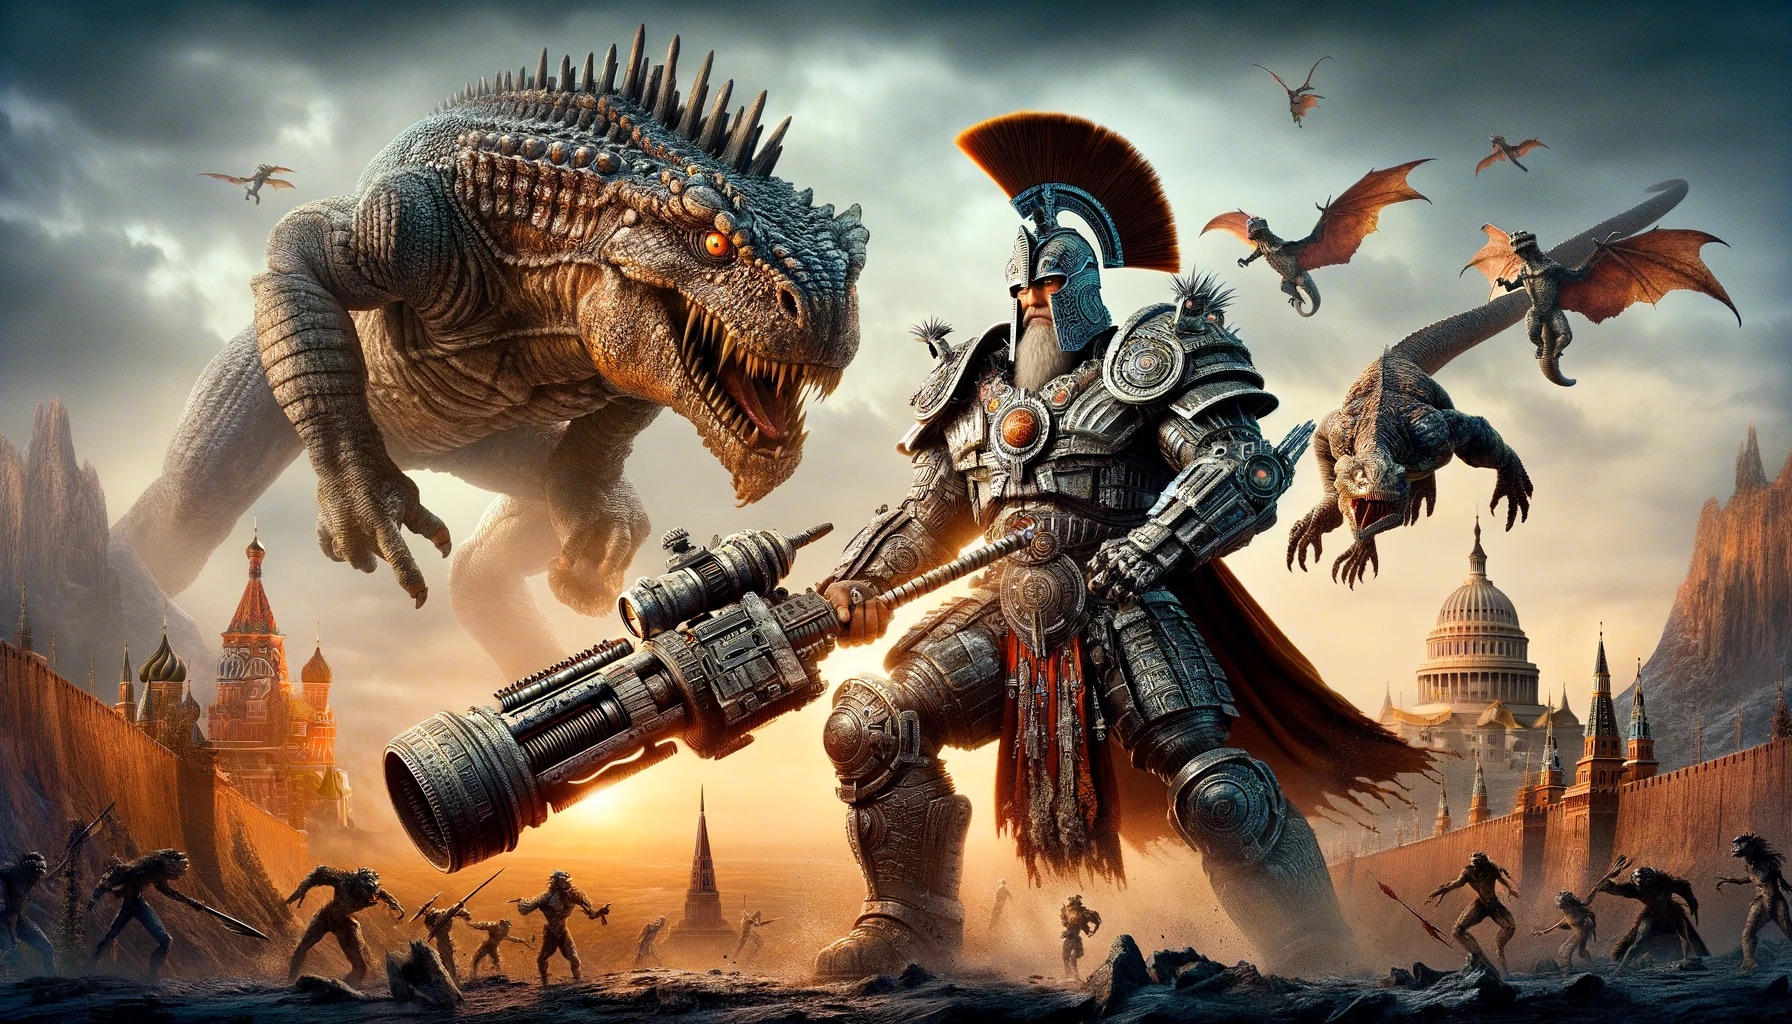

In [9]:
import urllib
url, filename = ("https://raw.githubusercontent.com/MerkulovDaniil/optim/master/assets/files/turboslavic.jpeg", "turboslavic.jpeg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

display(input_image)

### Implement power method for the singular value estimation

**Input:** convolutional layer of a neural network of type `torch.nn.modules.conv.Conv2d`, number of power method iterations.

**Output:** array of singular value estimations.

Important notes:
* We cannot build directly matrix $W$ of a convolutional layer, because it could be huge. But we can do matvec with `torch.nn.Conv2d()` forward pass!
* Also we will need matvec on $W^\top$ matrix. This is available with `torch.nn.ConvTranspose2d()` forward pass.
* We will need to setup biases of layers to zero in order to make pure matvecs.

In [10]:
@torch.no_grad()
def power_method_for_nn_layer(layer, n_iterations=10):
    sigmas = []
    x = copy.deepcopy(input_batch)

    # Create custom layer from pretrained layer:
    conv_layer = torch.nn.Conv2d(3, 64, 7, padding=3)
    conv_T_layer = torch.nn.ConvTranspose2d(64, 3, 7, padding=3)

    conv_layer.weight.data = copy.deepcopy(list(layer.parameters())[0].data)
    conv_layer.bias.data.zero_()

    conv_T_layer.weight.data = copy.deepcopy(list(layer.parameters())[0].data)
    conv_T_layer.bias.data.zero_()

    for i in range(n_iterations):
        
        # x norm
        x_norm = torch.norm(x)

        # y =   W@x computation
        y = conv_layer(x)

        # sigma computation
        y_norm = torch.norm(y)
        sigma = y_norm/x_norm
        sigmas.append(sigma)

        # x = W.T@y computation
        x = conv_T_layer(y)

        # Normalization
        x = x/x_norm
    
    return sigmas

### Plot method results

In [11]:
n_iter = 100
sigmas = power_method_for_nn_layer(model.conv1, n_iter)

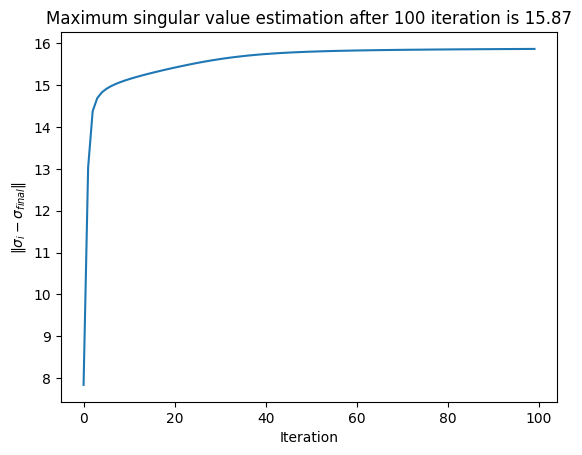

In [12]:
plt.ylabel(r'$\|\sigma_i - \sigma_{final}\|$')
plt.xlabel('Iteration')
plt.title(f'Maximum singular value estimation after {n_iter} iteration is {sigmas[-1]:.2f}')
plt.plot(sigmas)
plt.show()

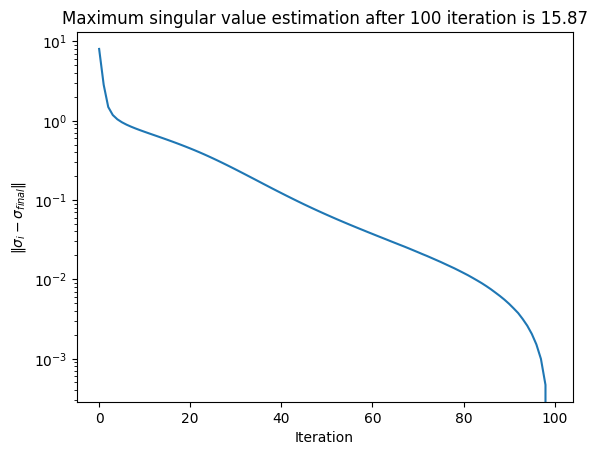

In [13]:
plt.ylabel(r'$\|\sigma_i - \sigma_{final}\|$')
plt.xlabel('Iteration')
plt.title(f'Maximum singular value estimation after {n_iter} iteration is {sigmas[-1]:.2f}')
plt.semilogy([abs(sigmas[-1] - sigma) for sigma in sigmas])
plt.show()

## Fourier will help
We can also estimate the maximum singular values of layer using Fourier transform, applied directly to the kernel tensor, as it was discussed in the lecture.

In [14]:
print(f"💩 Initial kernel shape {model.conv1.weight.data.shape}")
kernel = torch.permute(model.conv1.weight.data, [2, 3, 0, 1])
print(f"👨‍🔬 Kernel shape after correct reshaping {kernel.shape}")
input_shape = input_batch.shape
print(f"🌅 Image shape {input_shape}")
s = np.fft.fft2(kernel, (224, 224), axes=[0, 1])
s = np.linalg.svd(s, compute_uv=False)
print(f"🐺 Estimation of the maximum singular value is {np.max(s)}")

💩 Initial kernel shape torch.Size([64, 3, 7, 7])
👨‍🔬 Kernel shape after correct reshaping torch.Size([7, 7, 64, 3])
🌅 Image shape torch.Size([1, 3, 224, 224])
🐺 Estimation of the maximum singular value is 15.916427973378763
